In [1]:
import numpy as np # linear algebra
import re, os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


import datetime
from datetime import datetime

# BERT
import optimization
import run_classifier
import tokenization
import tensorflow_hub as hub

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Get the file details
directory = []
file = []
title = []
text = []
label = []

datapath = './archive/bbc-fulltext (document classification)/bbc/' 
for dirname, _ , filenames in os.walk(datapath):
    #print('Directory: ', dirname)
    #print('Subdir: ', dirname.split('/')[-1])
    # remove the Readme.txt file
    # will not find file in the second iteration so we skip the error
    try:
        filenames.remove('README.TXT')
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        label.append(dirname.split('/')[-1])
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)


In [3]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

df = pd.DataFrame(list(zip(directory, file, title, label, text)), 
               columns =['directory', 'file', 'title', 'label','text'])

# df = fulldf.filter(['label','text'], axis=1)
df.head()

,directory,file,title,label,text
0,./archive/bbc-fulltext (document classificatio...,289.txt,Musicians to tackle US red tape,entertainment,Musicians' groups are to tackle US visa regu...
1,./archive/bbc-fulltext (document classificatio...,262.txt,U2's desire to be number one,entertainment,"U2, who have won three prestigious Grammy Aw..."
2,./archive/bbc-fulltext (document classificatio...,276.txt,Rocker Doherty in on-stage fight,entertainment,Rock singer Pete Doherty has been involved i...
3,./archive/bbc-fulltext (document classificatio...,060.txt,Snicket tops US box office chart,entertainment,The film adaptation of Lemony Snicket novels...
4,./archive/bbc-fulltext (document classificatio...,074.txt,Ocean's Twelve raids box office,entertainment,"Ocean's Twelve, the crime caper sequel starr..."


In [4]:
df.shape

(2225, 5)

In [5]:
df.isnull().sum()

directory    0
file         0
title        0
label        0
text         0
dtype: int64

In [6]:
for label in np.unique(df['label']):
    print(label)

business
entertainment
politics
sport
tech


<Axes: >

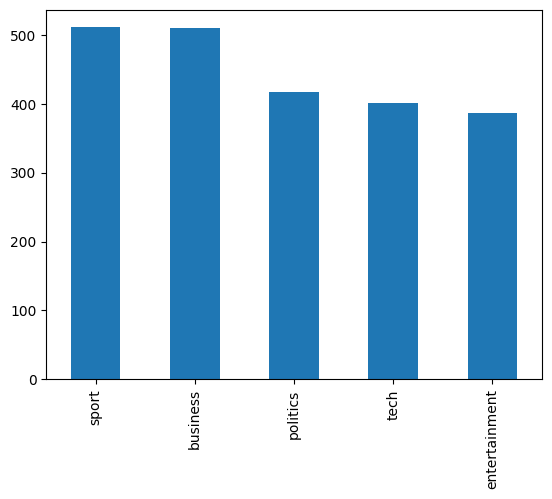

In [7]:
# Checking number of records of each label
df['label'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [8]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#     text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [9]:
df['text_clean'] = df['text'].apply(clean_text)
df['text_clean'] = df['text_clean'].str.replace('\d+', '')
df.head()

/var/folders/b2/hx3hnjy967d2_x_0tbdd6xzc0000gn/T/ipykernel_1470/2915232710.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text_clean'] = df['text_clean'].str.replace('\d+', '')


,directory,file,title,label,text,text_clean
0,./archive/bbc-fulltext (document classificatio...,289.txt,Musicians to tackle US red tape,entertainment,Musicians' groups are to tackle US visa regu...,musicians groups tackle us visa regulations bl...
1,./archive/bbc-fulltext (document classificatio...,262.txt,U2's desire to be number one,entertainment,"U2, who have won three prestigious Grammy Aw...",u three prestigious grammy awards hit vertigo ...
2,./archive/bbc-fulltext (document classificatio...,276.txt,Rocker Doherty in on-stage fight,entertainment,Rock singer Pete Doherty has been involved i...,rock singer pete doherty involved fight bands ...
3,./archive/bbc-fulltext (document classificatio...,060.txt,Snicket tops US box office chart,entertainment,The film adaptation of Lemony Snicket novels...,film adaptation lemony snicket novels topped n...
4,./archive/bbc-fulltext (document classificatio...,074.txt,Ocean's Twelve raids box office,entertainment,"Ocean's Twelve, the crime caper sequel starr...",oceans twelve crime caper sequel starring geor...


In [10]:
# def get_split(text1):
#     l_total = []
#     l_parcial = []
#     if len(text1.split())//150 >0:
#         n = len(text1.split())//150
# # why do we have an else?
#     else: 
#         n = 1
#     for w in range(n):
#         if w == 0:
#             l_parcial = text1.split()[:200]
#             l_total.append(" ".join(l_parcial))
#         else:
#             l_parcial = text1.split()[w*150:w*150 + 200]
#             l_total.append(" ".join(l_parcial))
#     return l_total

In [11]:
# df['text_split'] = df['text'].apply(get_split)
# df.head()

In [13]:
df['text_split'] = df['text_clean'].str.split()
df.head()

,directory,file,title,label,text,text_clean,text_split
0,./archive/bbc-fulltext (document classificatio...,289.txt,Musicians to tackle US red tape,entertainment,Musicians' groups are to tackle US visa regu...,musicians groups tackle us visa regulations bl...,"[musicians, groups, tackle, us, visa, regulati..."
1,./archive/bbc-fulltext (document classificatio...,262.txt,U2's desire to be number one,entertainment,"U2, who have won three prestigious Grammy Aw...",u three prestigious grammy awards hit vertigo ...,"[u, three, prestigious, grammy, awards, hit, v..."
2,./archive/bbc-fulltext (document classificatio...,276.txt,Rocker Doherty in on-stage fight,entertainment,Rock singer Pete Doherty has been involved i...,rock singer pete doherty involved fight bands ...,"[rock, singer, pete, doherty, involved, fight,..."
3,./archive/bbc-fulltext (document classificatio...,060.txt,Snicket tops US box office chart,entertainment,The film adaptation of Lemony Snicket novels...,film adaptation lemony snicket novels topped n...,"[film, adaptation, lemony, snicket, novels, to..."
4,./archive/bbc-fulltext (document classificatio...,074.txt,Ocean's Twelve raids box office,entertainment,"Ocean's Twelve, the crime caper sequel starr...",oceans twelve crime caper sequel starring geor...,"[oceans, twelve, crime, caper, sequel, starrin..."


In [15]:
df.to_csv('BBC_news.csv', index=False)  